In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
#from src.score import * # load_test_data defined here
from collections import OrderedDict

from tensorflow.keras.layers import Input, UpSampling3D, AveragePooling3D, concatenate, ReLU, Reshape, Concatenate, \
    Permute
#from DLWP.custom import CubeSpherePadding2D, CubeSphereConv2D
from tensorflow.keras.layers import Reshape, Concatenate, Permute
from tensorflow.keras.models import Model
import glob
from tensorflow.keras.models import load_model

import os
import numpy as np

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
import cv2
from patchify import * 
#import tensorly as tl

In [2]:
def mse(y, t):
    return np.mean(np.square(y - t))

def psnr(y, t, max_=200.0):
    return 20 * np.log10(max_) - 10 * np.log10(mse(y, t))

def ssim(x, y, max_=200.0):
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    var_x = np.var(x)
    var_y = np.var(y)
    cov = np.mean((x - mu_x) * (y - mu_y))
    c1 = np.square(0.01 * max_)
    c2 = np.square(0.03 * max_)
    return ((2 * mu_x * mu_y + c1) * (2 * cov + c2)) / ((mu_x**2 + mu_y**2 + c1) * (var_x + var_y + c2))

def calc_MI(X,Y,bins):

    c_XY = np.histogram2d(X,Y,bins)[0]
    c_X = np.histogram(X,bins)[0]
    c_Y = np.histogram(Y,bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)

    MI = H_X + H_Y - H_XY
    return MI

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

In [3]:
data_dir='../data/input_satellite_jaxa_gsmap'
file_ = glob.glob(data_dir+'GSMaP.v7_0.10deg_????-*_austin.nc')
ds = xr.open_mfdataset(file_, combine='by_coords')

In [4]:
ds_test  = ds.sel(time=slice('2010', '2020'))
min_ = 0.0 # min_max.values[0]
max_ = 200.0 #min_max.values[1]

In [5]:
weight_filename = 'srcnn_weight_20085.hdf5'
weight_filename = 'srcnn_weight_20088.hdf5' # 149 psnr for 20089.hdf5, 149.49 for 20088.hdf5
model = Sequential()
model.add(Conv2D(64,9,padding='same',input_shape=(20,20,1)))
model.add(Activation('relu'))
model.add(Conv2D(32,1,padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(1,5,padding='same'))
# optimizer = Adam(lr=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
model.load_weights(os.path.join('./model/',weight_filename))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
ds_test  = ds.sel(time=slice('2010', '2020'))
year = 2010
X_pred_ = []
X_cubic_ = []
y_ = []

for year in range(2010,2019):
    data_ = ds_test.pr.sel(time=slice(str(year), str(year))).values
    data_n = 2*((data_[:,:,:]-min_)/(max_-min_))
    #print(data_.shape, data_n.shape)

    X = []
    y = []
    for i_ in range(data_n.shape[0]):
        img = data_n[i_,:,:]
        if True:#np.sum(img)>0:
            scale = 2
            res = cv2.resize(img, dsize=(img.shape[0]*scale, img.shape[1]*scale), interpolation=cv2.INTER_CUBIC)
            res_ = cv2.resize(res, dsize=(int(res.shape[0]*(1/scale)), \
                                              int(res.shape[1]*(1/scale))), interpolation=cv2.INTER_CUBIC)
                #data_n_[i_,:,:] = res _
            X.append(img)
            y.append(res_)
    X = np.asarray(X)
    X_pred = np.copy(X)
    y = np.asarray(y) 
    print(year)
    for i_x in range(X.shape[0]):
        image = X[i_x]
        sub_images_ = patchify(X[i_x], (20,20), step=10)
        patches =np.copy(sub_images_)
        for i_p in range(patches.shape[0]):
            for j_p in range(patches.shape[1]):
                sub_pred = model.predict(sub_images_[i_p,j_p,np.newaxis,:,:,np.newaxis])[0]
                patches[i_p,j_p] =  sub_pred[:,:,0]
        patches[sub_images_==0.0] = 0.0
        reconstructed_image = unpatchify(patches, image.shape)
        X_pred[i_x,:,:] = reconstructed_image
    X_pred_.append(X_pred)
    X_cubic_.append(X)
    y_.append(y)
    ds_write = ds_test.pr.sel(time=slice(str(year), str(year)))
    ds_write['pr_srcnn'] = (('time', 'lat', 'lon'), X_pred*200)
    ds_write['pr_cubic'] = (('time', 'lat', 'lon'), X*200)
    ds_write.to_netcdf('srcnn_'+str(year)+'.nc')
    print(data_.shape, X_pred.shape)
    

2010
(8760, 30, 30) (8760, 30, 30)
2011
(8760, 30, 30) (8760, 30, 30)
2012
(8784, 30, 30) (8784, 30, 30)
2013
(8760, 30, 30) (8760, 30, 30)
2014
(8760, 30, 30) (8760, 30, 30)
2015
(8760, 30, 30) (8760, 30, 30)
2016
(8784, 30, 30) (8784, 30, 30)
2017
(8760, 30, 30) (8760, 30, 30)
2018
(8760, 30, 30) (8760, 30, 30)


In [7]:
X_pred_ = np.asarray(X_pred_)
X_cubic_ = np.asarray(X_cubic_)
y_ =     np.asarray(y_)

/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [8]:
#ds.pr.sel(time=slice('2010','2018'))
#print(8760*9)
X_pred__ = np.zeros_like((ds.pr.sel(time=slice('2010','2018')).values))
X_cubic__ = np.zeros_like((ds.pr.sel(time=slice('2010','2018')).values))
y__ = np.zeros_like((ds.pr.sel(time=slice('2010','2018')).values))
cnt_s=0
cnt_e=0
for i in range(X_pred_.shape[0]):
    cnt_e = cnt_s + X_pred_[i].shape[0]
    X_pred__[cnt_s:cnt_e,:,:]  = X_pred_[i]
    X_cubic__[cnt_s:cnt_e,:,:] = X_cubic_[i]
    y__[cnt_s:cnt_e,:,:] = y_[i]
    cnt_s = cnt_e
#X_pred_.flatten().shape

In [9]:
ds_ = ds.sel(time=slice('2010','2018'))
ds_['x_pred_srcnn']  =(('time', 'lat', 'lon'), X_pred__)
ds_['x_cubic']  =(('time', 'lat', 'lon'), X_cubic__)
ds_['y']  =(('time', 'lat', 'lon'), y__)

In [10]:
ds_.to_netcdf('prediction_srcnn_weight_20088.nc')

In [12]:
psnr_dl = []
psnr_cu = []
ssim_dl = []
ssim_cu = []
mse_dl = []
mse_cu = []
for i in range(9):
    for j in range(X_pred_[i].shape[0]):
        #print(psnr(X_pred_[i][~np.isnan(X_pred_[i])], y_[i][~np.isnan(y_[i])]), \
        #      psnr(X_cubic_[i][~np.isnan(X_cubic_[i])], y_[i][~np.isnan(y_[i])]))
        try:
            psnr_dl.append(psnr(X_pred_[i][j][~np.isnan(X_pred_[i][j])], y_[i][j][~np.isnan(y_[i][j])]))
            psnr_cu.append(psnr(X_cubic_[i][j][~np.isnan(X_cubic_[i][j])], y_[i][j][~np.isnan(y_[i][j])]))
            mse_dl.append(mse(X_pred_[i][j][~np.isnan(X_pred_[i][j])], y_[i][j][~np.isnan(y_[i][j])]))
            mse_cu.append(mse(X_cubic_[i][j][~np.isnan(X_cubic_[i][j])], y_[i][j][~np.isnan(y_[i][j])]))
            ssim_dl.append(ssim(X_pred_[i][j][~np.isnan(X_pred_[i][j])], y_[i][j][~np.isnan(y_[i][j])]))
            ssim_cu.append(ssim(X_cubic_[i][j][~np.isnan(X_cubic_[i][j])], y_[i][j][~np.isnan(y_[i][j])]))
        except:
            continue
#         print(psnr(X_pred_[i][~np.isnan(X_pred_[i])], y_[i][~np.isnan(y_[i])]), \
#               psnr(X_cubic_[i][~np.isnan(X_cubic_[i])], y_[i][~np.isnan(y_[i])]))

/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods

In [14]:
psnr_dl_2010_2019 = np.asarray(psnr_dl)
psnr_dl_2010_2019 = psnr_dl_2010_2019[~np.isnan(psnr_dl_2010_2019)]
psnr_cu_2010_2019 = np.asarray(psnr_cu)
psnr_cu_2010_2019 = psnr_cu_2010_2019[~np.isnan(psnr_cu_2010_2019)]

In [16]:
mse_dl_2010_2019 = np.asarray(mse_dl)
mse_dl_2010_2019 = mse_dl_2010_2019[~np.isnan(mse_dl_2010_2019)]
mse_cu_2010_2019 = np.asarray(mse_cu)
mse_cu_2010_2019 = mse_cu_2010_2019[~np.isnan(mse_cu_2010_2019)]

In [17]:
import pandas as pd
import seaborn as sns

d = {'data':psnr_dl_2010_2019, 'type':'srcnn'}
df = pd.DataFrame(d)
d = {'data':psnr_cu_2010_2019, 'type':'cubic'}
df1 =  pd.DataFrame(d)
df = df.append(df1)

/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1156: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)
/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1156: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)


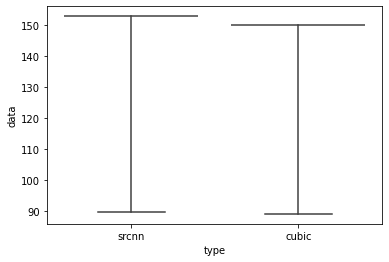

In [18]:
sns.boxplot(x='type', y='data', data = df)

In [19]:
psnr_srcnn_mean_ = df[df['type']=='srcnn'].values[:,0]
psnr_cubic_mean_ = df[df['type']=='cubic'].values[:,0]

In [20]:
np.mean(psnr_srcnn_mean_[psnr_srcnn_mean_<500])

149.49477287439456

In [21]:
np.mean(psnr_cubic_mean_[psnr_cubic_mean_<500])

146.95788266951305

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 64)        5248      
_________________________________________________________________
activation (Activation)      (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        2080      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [28]:
ds_pred_np = ds_['x_pred_srcnn'].mean(dim='time').values*200

In [29]:
def iterate_srcnn(ds, scale = 2):
    ds_pred_np = ds.values
    res = cv2.resize(ds_pred_np, dsize=(ds_pred_np.shape[0]*scale, ds_pred_np.shape[1]*scale), \
                     interpolation=cv2.INTER_CUBIC)
    sub_images_ = patchify(res, (20,20), step=10)
    patches =np.copy(sub_images_)
    for i_p in range(patches.shape[0]):
        for j_p in range(patches.shape[1]):
            sub_pred = model.predict(sub_images_[i_p,j_p,np.newaxis,:,:,np.newaxis])[0]
            patches[i_p,j_p] =  sub_pred[:,:,0]
    patches[sub_images_==0.0] = 0.0
    reconstructed_image = unpatchify(patches, res.shape)
    X_srcnn = reconstructed_image
    newlat =np.linspace(ds.lat.values[0], ds.lat.values[-1], num=res.shape[0])
    newlon =np.linspace(ds.lon.values[0], ds.lon.values[-1], num=res.shape[0])
    ds_ = xr.Dataset({
    'pr': xr.DataArray(
                data   = X_srcnn,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': newlat, 'lon':newlon},
                ),
            },
    )
    return ds_

In [30]:
def iterate_cubic(ds, scale = 2):
    ds_pred_np = ds.values
    #print(ds_pred_np.shape[0])
    res = cv2.resize(ds_pred_np, dsize=(ds_pred_np.shape[0]*(scale), ds_pred_np.shape[1]*(scale)), interpolation=cv2.INTER_CUBIC)
    X_cubic = res
    newlat =np.linspace(ds.lat.values[0], ds.lat.values[-1], num=res.shape[0])
    newlon =np.linspace(ds.lon.values[0], ds.lon.values[-1], num=res.shape[0])
    ds_ = xr.Dataset({
    'pr': xr.DataArray(
                data   = X_cubic,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': newlat, 'lon':newlon},
                ),
            },
    )
    return ds_

In [31]:
ds_hr1 = iterate_srcnn(ds_['x_pred_srcnn'].sel(time='2013-01-04T20:00:00'))
ds_hr2 = iterate_srcnn(ds_hr1.pr)
ds_hr3 = iterate_srcnn(ds_hr2.pr)
ds_hr4 = iterate_srcnn(ds_hr3.pr)
ds_hr5 = iterate_srcnn(ds_hr4.pr)

In [37]:
ds_cubic_hr1 = iterate_cubic(ds_['x_cubic'].sel(time='2013-01-04T20:00:00'))
ds_cubic_hr2 = iterate_cubic(ds_cubic_hr1.pr)
ds_cubic_hr3 = iterate_cubic(ds_cubic_hr2.pr)
ds_cubic_hr4 = iterate_cubic(ds_cubic_hr3.pr)
ds_cubic_hr5 = iterate_cubic(ds_cubic_hr4.pr)

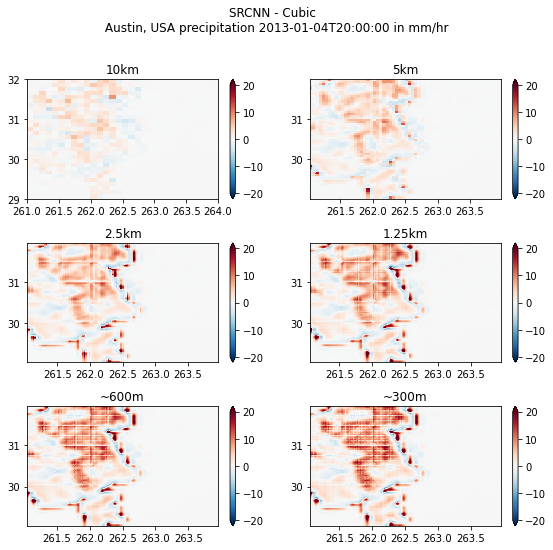

In [39]:
fig,ax = plt.subplots(ncols=2,nrows=3, figsize=(8,8))
ds_diff = (ds_['x_pred_srcnn'].sel(time='2013-01-04T20:00:00') - ds_['x_cubic'].sel(time='2013-01-04T20:00:00'))*200
ds_diff.plot(ax=ax[0,0],vmax=20, extend='both', cbar_kwargs={'label': ''})

ds_diff  = (ds_hr1.pr - ds_cubic_hr1.pr)*200
ds_diff.plot(ax=ax[0,1],vmax=20, extend='both', cbar_kwargs={'label': ''})

ds_diff  = (ds_hr2.pr - ds_cubic_hr2.pr)*200
ds_diff.plot(ax=ax[1,0],vmax=20, extend='both', cbar_kwargs={'label': ''})

ds_diff  = (ds_hr3.pr - ds_cubic_hr3.pr)*200
ds_diff.plot(ax=ax[1,1],vmax=20, extend='both', cbar_kwargs={'label': ''})

ds_diff  = (ds_hr4.pr - ds_cubic_hr4.pr)*200
ds_diff.plot(ax=ax[2,0],vmax=20, extend='both', cbar_kwargs={'label': ''})

ds_diff  = (ds_hr5.pr - ds_cubic_hr5.pr)*200
ds_diff.plot(ax=ax[2,1],vmax=20, extend='both', cbar_kwargs={'label': ''})

res_ = ['10km', '5km', '2.5km', '1.25km', '~600m', '~300m']
cnt = 0
for i_ in range(3):
    for j_ in range(2):
        ax[i_,j_].set_title(res_[cnt])
        ax[i_,j_].set_xlabel('')
        ax[i_,j_].set_ylabel('')
        cnt=cnt+1
fig.suptitle('SRCNN - Cubic \n Austin, USA precipitation 2013-01-04T20:00:00 in mm/hr')
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('srcnn_cubic_diff.png', dpi=500)

0 0
0 1
1 0
1 1
2 0


/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


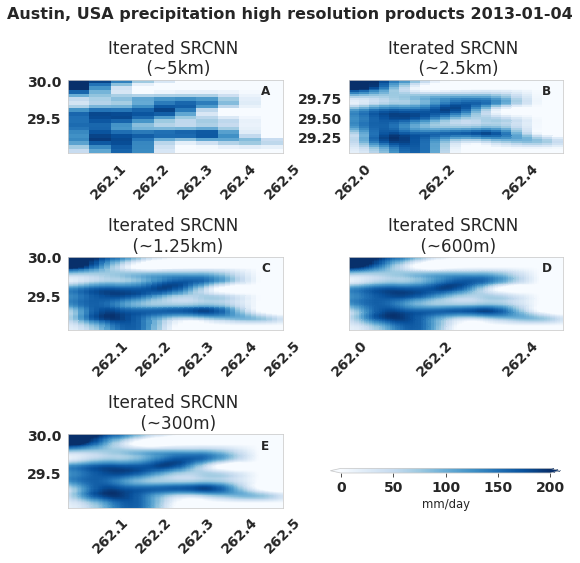

In [119]:
fig,ax = plt.subplots(ncols=2,nrows=3, figsize=(8,8))
fig.delaxes(ax[2,1])
tits_ = ['Iterated SRCNN \n (~5km)', 'Iterated SRCNN \n (~2.5km)', 'Iterated SRCNN \n (~1.25km)', \
        'Iterated SRCNN \n (~600m)', 'Iterated SRCNN \n (~300m)']
ds_p = [ ds_hr1.pr.sel(lon=slice(262,262.5)).sel(lat=slice(30,29))*200, \
        ds_hr2.pr.sel(lon=slice(262,262.5)).sel(lat=slice(30,29))*200, \
        ds_hr3.pr.sel(lon=slice(262,262.5)).sel(lat=slice(30,29))*200, \
        ds_hr4.pr.sel(lon=slice(262,262.5)).sel(lat=slice(30,29))*200, \
        ds_hr5.pr.sel(lon=slice(262,262.5)).sel(lat=slice(30,29))*200, \
        ]
label_c = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
cnt=0
for i in range(3):
    for j in range(2):
        print(i,j)
        im = ds_p[cnt].plot(ax=ax[i,j], cmap='Blues', vmin=0, vmax=200,add_colorbar=False)
        ax[i,j].set_title(tits_[cnt])
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')
        ax[i,j].annotate(label_c[cnt], xy=(0.9, 0.8) ,xycoords="axes fraction", weight='bold', size=12)
        ax[i,j].tick_params(axis='x', rotation=45)
#         gl = ax[i,j].gridlines(color='gray',alpha=0.6,draw_labels=True) 
#         #gl.xlabels_top, gl.ylabels_right = False, False
#         gl.xlabel_style, gl.ylabel_style = {'fontsize': 14}, {'fontsize': 14}
        cnt=cnt+1
        if cnt>3:
            break
#         if cnt<4:
#             print(ds_p[cnt].values.shape)
#             grid_ = ds_p[cnt].values

#             for (j_,i_),label in np.ndenumerate(grid_):
#                 ax[i,j].text(i_,j_,label,ha='center',va='center')
                #ax2.text(i,j,label,ha='center',va='center')
        
    #ax[i].coastlines()
    

ax[1,1].set_yticklabels([''])
ax[2,1].set_yticklabels([''])


cbar_ax = fig.add_axes([0.57, 0.17, 0.4, 0.008])

cb = fig.colorbar(im, extend='both', cax=cbar_ax, orientation='horizontal')
cbar_ax.set_xlabel("mm/day", fontname='Arial', fontsize='small')
fig.suptitle('Austin, USA precipitation high resolution products 2013-01-04', weight='bold', size=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('srcnn_product.png', dpi=500)

/lus/dal/cccr_rnd/manmeet/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


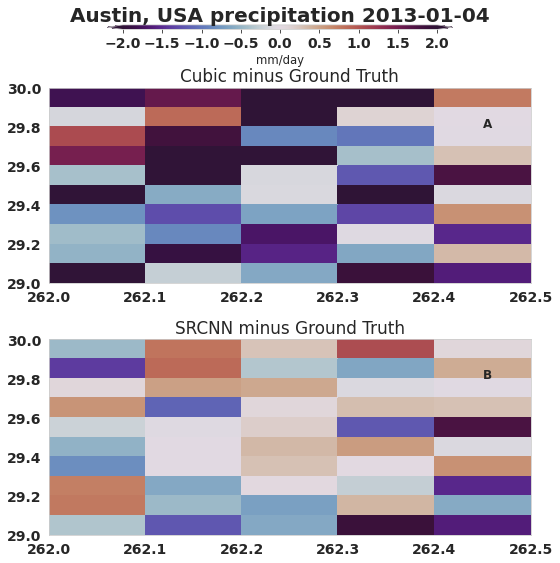

In [115]:
import matplotlib.gridspec as gridspec
ds_gt_    = ds_['y'].sel(time='2013-01-04T20:00:00')*200
ds_cubic_diff = ds_['x_cubic'].sel(time='2013-01-04T20:00:00')*200 - ds_gt_
ds_pred_diff  = ds_['x_pred_srcnn'].sel(time='2013-01-04T20:00:00')*200 - ds_gt_
label_c = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
fig,ax = plt.subplots(ncols=1,nrows=2, figsize=(8,8))
gs1 = gridspec.GridSpec(1, 2)
im  = ds_cubic_diff.sel(lon=slice(262,262.5)).sel(lat=slice(30,29)).plot(ax=ax[0], cmap='twilight_shifted', vmin=-2, vmax=2, add_colorbar=False)
im  = ds_pred_diff.sel(lon=slice(262,262.5)).sel(lat=slice(30,29)).plot(ax=ax[1], cmap='twilight_shifted', vmin=-2, vmax=2, add_colorbar=False)


ax[0].set_title('Cubic minus Ground Truth')
ax[1].set_title('SRCNN minus Ground Truth')
cnt=0
for ax in [ax[0], ax[1]]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.annotate(label_c[cnt], xy=(0.9, 0.8) ,xycoords="axes fraction", weight='bold', size=12)
    cnt=cnt+1

cbar_ax = fig.add_axes([0.2, 0.94, 0.6, 0.008])
cb = fig.colorbar(im, extend='both', cax=cbar_ax, orientation='horizontal')
fig.suptitle('Austin, USA precipitation 2013-01-04', weight='bold', size=20)
cbar_ax.set_xlabel("mm/day", fontname='Arial', fontsize='small')
# fig.suptitle('')
fig.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('validation_10km.png', dpi=500)

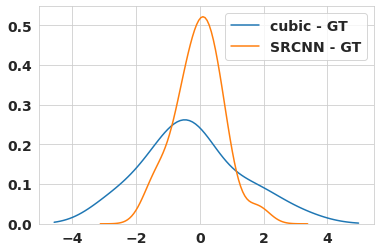

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)
data_ = {'data':ds_cubic_diff.sel(lon=slice(262,262.5)).sel(lat=slice(30,29)).values.flatten(), 'type':'cubic'}
df1 = pd.DataFrame(data_)
data_ = {'data':ds_pred_diff.sel(lon=slice(262,262.5)).sel(lat=slice(30,29)).values.flatten(), 'type':'pred'}
df2 = pd.DataFrame(data_)

df = df1.append(df2)
#print(df)
sns.set_style('whitegrid')
sns.kdeplot(np.array(df1.data.values), bw=0.5, label='cubic - GT ')
sns.kdeplot(np.array(df2.data.values), bw=0.5, label='SRCNN - GT')
plt.savefig('distributions_austin_prec_downscaling.png', dpi=500)

In [40]:
ds_find_largest = ds_.pr.sum(dim='lat').sum(dim='lon').values

In [41]:
np.max(ds_find_largest)

36808.348

In [42]:
np.where(ds_find_largest==36808.348)

(array([26396]),)

In [43]:
ds_.isel(time=26396)

<xarray.Dataset>
Dimensions:       (lat: 30, lon: 30)
Coordinates:
    time          datetime64[ns] 2013-01-04T20:00:00
  * lon           (lon) float64 261.1 261.1 261.2 261.3 ... 263.8 263.8 263.9
  * lat           (lat) float64 31.95 31.85 31.75 31.65 ... 29.25 29.15 29.05
Data variables:
    pr            (lat, lon) float32 dask.array<chunksize=(30, 30), meta=np.ndarray>
    x_pred_srcnn  (lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    x_cubic       (lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    y             (lat, lon) float32 3.0394851e-05 -0.0023878273 ... 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Apr 30 11:57:21 2021: cdo sellonlatbox,261,264,29,32 GS...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...